# An unoffical demo for training MCNN on Shanghai tech dataset (Part-B)

## Imports

In [23]:
import pandas as pd
import numpy as np

In [24]:
import scipy
import scipy.io
import cv2

from matplotlib import pyplot as plt

from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from PIL import Image

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning import seed_everything

import os

## visualize

In [25]:
def show(im):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

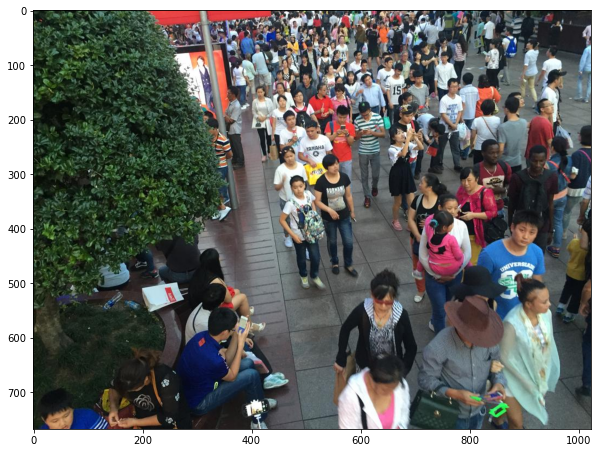

In [26]:
im = cv2.imread('../input/shanghaitech/ShanghaiTech/part_B/train_data/images/IMG_1.jpg', cv2.IMREAD_COLOR)
show(im)

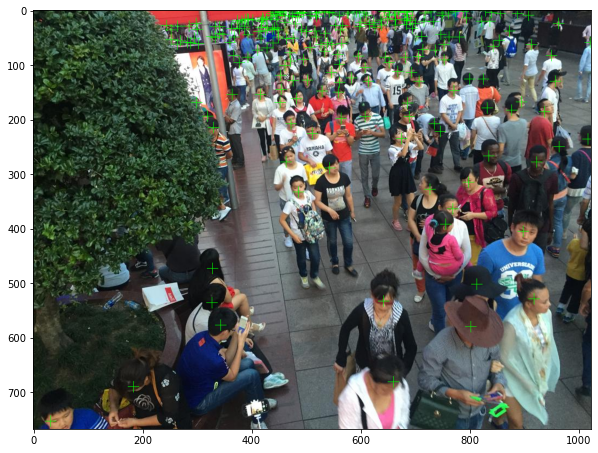

In [27]:
m = scipy.io.loadmat('../input/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth/GT_IMG_1.mat')
ps = m['image_info'][0][0][0][0][0]

for x, y in ps:
    x = int(x)
    y = int(y)
    cv2.drawMarker(im, (x, y), (0, 255, 0))
    
show(im)

## Prepare dataset

In [28]:
from sklearn.model_selection import train_test_split

train = [p.path for p in os.scandir('../input/shanghaitech/ShanghaiTech/part_B/train_data/images/')]
valid_full = [p.path for p in os.scandir('../input/shanghaitech/ShanghaiTech/part_B/test_data/images/')]

## use a small subset for validation
_, valid = train_test_split(valid_full, test_size=64, random_state=42)

len(train), len(valid)

(400, 64)

In [29]:
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [30]:
im_size = 512
aug_train = A.Compose([
    A.RandomCrop(im_size, im_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

aug_val = A.Compose([
    A.Resize(768, 1024),
    A.Normalize((0.5), (0.5)),
], keypoint_params=A.KeypointParams(format='xy', angle_in_degrees=False))

class MyDataset(Dataset):
    def __init__(self, files, aug):
        self.files = files
        self.aug = aug
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fn = self.files[idx]
        
        im = cv2.imread(fn, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        
        m = scipy.io.loadmat(fn.replace('images', 'ground-truth').replace('IMG', 'GT_IMG').replace('.jpg', '.mat'))
        ps = m['image_info'][0][0][0][0][0]
        
        rst = self.aug(image=im, keypoints=ps)
        im = rst['image']
        ps = rst['keypoints']
        
        dm = np.zeros((im.shape[0], im.shape[1]), dtype=np.float32)
        for x, y in ps:
            x = int(x)
            y = int(y)
            dm[y, x] = 1

        sigma = 4
        dm = gaussian_filter(dm, sigma=sigma, truncate=4*sigma)
        
        dm = cv2.resize(dm, (im.shape[1] // 4, im.shape[0] // 4), interpolation=cv2.INTER_LINEAR)
        dm *= 16
        
        im = torch.from_numpy(im)
        dm = torch.from_numpy(dm)
        
        return im, dm

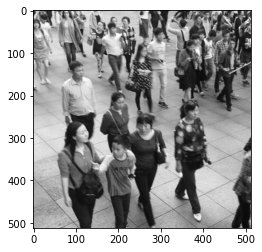

In [31]:
ds = MyDataset(train, aug_train)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

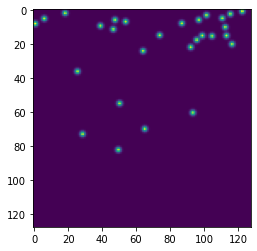

In [32]:
plt.imshow(dm)

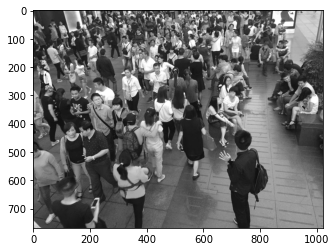

In [33]:
ds = MyDataset(valid, aug_val)
im, dm = ds[0]
plt.imshow(im, cmap='gray')

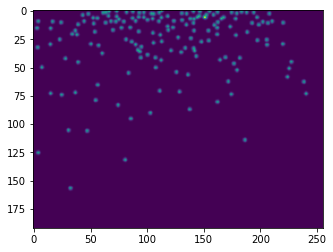

In [34]:
plt.imshow(dm)

In [35]:
dm.sum()

tensor(165.)

## Building Model

In [36]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


In [37]:
class MCNN(LightningModule):
    '''
    Multi-column CNN 
        -Implementation of Single Image Crowd Counting via Multi-column CNN (Zhang et al.)
    '''
    
    def __init__(self, lr, batch_size, max_steps, bn=False):
        super(MCNN, self).__init__()
        
        self.lr = lr
        self.save_hyperparameters()
        
        self.use = 0
        
        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))
        
        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))
        
        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))
        
        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
        
        self.out1 = nn.Sequential(Conv2d( 8, 1, 1, same_padding=True, bn=bn))
        self.out2 = nn.Sequential(Conv2d( 10, 1, 1, same_padding=True, bn=bn))
        self.out3 = nn.Sequential(Conv2d( 12, 1, 1, same_padding=True, bn=bn))
        
        self.crit = nn.MSELoss()
        
    def forward(self, im_data):
        im_data = im_data.unsqueeze(1)
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        
        
        if self.use == 0:
            x = torch.cat((x1,x2,x3),1)
            x = self.fuse(x)
        elif self.use == 1:
            x = self.out1(x1)
        elif self.use == 2:
            x = self.out2(x2)
        elif self.use == 3:
            x = self.out3(x3)
        
        return x.squeeze(1)
    
    
    def training_step(self, batch, batch_idx):
        self.train()
        x, y = batch
        
        pred = self(x)
        loss = self.crit(pred, y)
        
        pred_sum = torch.round(pred.sum(dim=(1,2))).int()
        gt_sum = torch.round(y.sum(dim=(1,2))).int()
        acc = (pred_sum == gt_sum).float().mean()
        
        mae = torch.abs(pred_sum - gt_sum).float().mean()
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        self.log('train_mae', mae)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            self.eval()
            x, y = batch
            
            pred = self(x)
            loss = self.crit(pred, y)
        
            pred_sum = torch.round(pred.sum(dim=(1,2))).int()
            gt_sum = torch.round(y.sum(dim=(1,2))).int()
            acc = (pred_sum == gt_sum).float().mean()

            mae = torch.abs(pred_sum - gt_sum).float().mean()
            
            self.log('val_loss', loss)
            self.log('val_acc', acc)
            self.log('val_mae', mae)
            
            
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.lr, total_steps=self.hparams.max_steps, pct_start=0.1, cycle_momentum=False),
            'interval': 'step',
            'frequency': 1
        }
        
        return [optimizer], [scheduler]

### weight init is crucial for the model to converge

In [38]:
def weights_normal_init(model, dev=0.01):
    if isinstance(model, list):
        for m in model:
            weights_normal_init(m, dev)
    else:
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, dev)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, dev)

## Training

In [39]:
batch_size = 32
epochs = 300
max_steps = epochs * len(train) // batch_size

In [40]:
train_loader = DataLoader(MyDataset(train, aug_train), batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(MyDataset(valid, aug_val), batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

### training

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
seed_everything(42)

checkpoint_cb = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
    verbose=True,
    monitor='val_mae',
    mode='min',
    prefix=''
)

trainer = Trainer(max_steps=max_steps, precision=16, benchmark=True, callbacks=[checkpoint_cb, LearningRateMonitor()]) # gpus=1 없으면 default = cpu

lr = 3e-4

model = MCNN(lr, batch_size, max_steps)
weights_normal_init(model, dev=0.01)

model.use = 0

trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

## Separate column training

In [ ]:
# from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
# seed_everything(42)

# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# lr = 3e-4

# model = MCNN(lr, batch_size, max_steps)
# weights_normal_init(model, dev=0.01)

# model.use = 1

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

In [ ]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 2

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

In [ ]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 3

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

In [ ]:
# checkpoint_cb = ModelCheckpoint(
#     save_top_k=1,
#     save_last=True,
#     verbose=True,
#     monitor='val_mae',
#     mode='min',
#     prefix=''
# )

# trainer = Trainer(gpus=1, max_steps=max_steps, precision=32, callbacks=[checkpoint_cb, LearningRateMonitor()])

# model.use = 0

# trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

## Visualize the result
We can see that the recognition results highlight the human body

In [ ]:
ds = MyDataset(valid, aug_val)
d = ds[0][0]
plt.imshow(d, cmap='gray')

In [ ]:
plt.imshow(model(d.unsqueeze(0)).detach()[0])

In [ ]:
model(d.unsqueeze(0)).detach()[0].sum()